# Friday Formative 

As already discussed in class, this week's formative is designed as a open-ended API task, so we're looking forward to seeing what you can do!

* Find an API for a website/platform of your choice not already used in class (e.g. from https://www.programmableweb.com/).
* Authenticate and use it to access some data.
* Apply some sort of wrangling techniques, merging, grouping, filtering etc., to the data.
* Provide some interesting observations, descriptions and plots of the data you find, perhaps with a simple statistical test (see scipy.stats) 

Bear in mind that the marker will have to be able to run the script, so will need the necessary access credentials. In addition, since the task is open to your own interpretation, some healthy commenting to guide the markers would be very welcome.


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, scipy as sp, statsmodels.api as sm
import datetime, time, requests, json, urllib.request
from pandas.io.json import json_normalize 
%matplotlib inline

# Creating functions to simplify the requests for weather

# Used to convert the time of request into readable format
def time_converter(time): 
    converted_time = datetime.datetime.fromtimestamp(
        int(time)
    ).strftime('%I:%M %p')
    return converted_time

# Converting the city ids into urls that would be used to request data
# My APIID is included so you can make requests. 
# NB: The terms of the API say you can't make more than 60 requests an hour but I did more than that and it was fine
def url_builder(city_id): 
    api = 'http://api.openweathermap.org/data/2.5/weather?id='
    full_api_url = api + str(city_id) + '&APPID=XXXXXXXXXXXXXX'
    return full_api_url

# Fetching the data
def data_fetch(full_api_url): 
    url = urllib.request.urlopen(full_api_url)
    output = url.read().decode('utf-8')
    raw_api_dict = json.loads(output)
    url.close()
    return raw_api_dict

# Attempted to use json normalise but that didn't work out well so using this to organise the data
def data_organizer(raw_api_dict): 
    data = dict(
        city=raw_api_dict.get('name'),
        country=raw_api_dict.get('sys').get('country'),
        temp=raw_api_dict.get('main').get('temp'),
        temp_max=raw_api_dict.get('main').get('temp_max'),
        temp_min=raw_api_dict.get('main').get('temp_min'),
        humidity=raw_api_dict.get('main').get('humidity'),
        pressure=raw_api_dict.get('main').get('pressure'),
        sky=raw_api_dict['weather'][0]['main'],
        sunrise=time_converter(raw_api_dict.get('sys').get('sunrise')),
        sunset=time_converter(raw_api_dict.get('sys').get('sunset')),
        wind=raw_api_dict.get('wind').get('speed'),
        wind_deg=raw_api_dict.get('deg'),
        dt=time_converter(raw_api_dict.get('dt')),
        cloudiness=raw_api_dict.get('clouds').get('all')
    )
    return data

# Checking to see if we can get the weather for a city using the codes from the cities code list
def check_weather(data):
    m_symbol = '\xb0' + 'K'
    print('---------------------------------------')
    print('Current weather in: {}, {}:'.format(data['city'], data['country']))
    print(data['temp'], m_symbol, data['sky'])
    print('Max: {}, Min: {}'.format(data['temp_max'], data['temp_min']))
    print('')
    print('Wind Speed: {}, Degree: {}'.format(data['wind'], data['wind_deg']))
    print('Humidity: {}'.format(data['humidity']))
    print('Cloud: {}'.format(data['cloudiness']))
    print('Pressure: {}'.format(data['pressure']))
    print('Sunrise at: {}'.format(data['sunrise']))
    print('Sunset at: {}'.format(data['sunset']))
    print('')
    print('Last update was at: {}'.format(data['dt']))
    print('---------------------------------------')


# Testing 1, 2, 3!
if __name__ == '__main__':
    try:
        check_weather(data_organizer(data_fetch(url_builder(1857578))))
    except IOError:
        print('Oh no! Error')

---------------------------------------
Current weather in: Matoba, JP:
284.546 °F Clouds
Max: 284.546, Min: 284.546

Wind Speed: 5.01, Degree: None
Humidity: 100
Cloud: 48
Pressure: 1000.92
Sunrise at: 10:20 PM
Sunset at: 08:14 AM

Last update was at: 08:45 PM
---------------------------------------


In [2]:
# The API provides codes for the cities which I downloaded to use. I've attached the file with my assignment
with open('city.list.json') as c:
    city_codes = json.load(c)

cities_df = json_normalize(city_codes)
display(cities_df.head())

,coord.lat,coord.lon,country,id,name
0,44.549999,34.283333,UA,707860,Hurzuf
1,55.683334,37.666668,RU,519188,Novinki
2,28.000000,84.633331,NP,1283378,Gorkhā
3,29.000000,76.000000,IN,1270260,State of Haryāna
4,44.599998,33.900002,UA,708546,Holubynka


In [3]:
# My weather dataframe 
weather_df = pd.DataFrame(columns=['city', 'country', 'temp', 'temp_max', 'temp_min', 'humidity', 'pressure', 'sky', 'sunrise', 'sunset', 'wind', 'wind_deg', 'dt', 'cloudiness'])

# Looping to add data to my dataframe. Aware that there are potential server errors that need to be caught here so will come back to de-bug!
for city_id in cities_df['id'][0:100]:
    url = url_builder(city_id)
    request = data_fetch(url)
    output = data_organizer(request)
    city_df = pd.DataFrame.from_dict(output,  orient='index').T
    weather_df = weather_df.append(city_df)

# Reindexing to catch an error in the data received. North America did not have a country code, but North America isn't even a city or country!
# I'll be placing a 'NA' here so it doesn't mess with my plots in the mean time.
weather_df = weather_df.set_index('city')
weather_df['country']['North America'] = 'NA'

# And what do we have?
display(weather_df.head())

,country,temp,temp_max,temp_min,humidity,pressure,sky,sunrise,sunset,wind,wind_deg,dt,cloudiness
city,,,,,,,,,,,,,
Hurzuf,UA,288.121,288.121,288.121,97,1017.05,Clear,04:15 AM,02:36 PM,2.51,None,08:45 PM,0
Novinki,RU,276.9,278.15,275.15,100,1018,Rain,04:28 AM,01:57 PM,2,None,08:00 PM,75
Gorkhā,NP,278.146,278.146,278.146,76,811.08,Clear,01:30 AM,11:39 AM,0.86,None,08:47 PM,0
State of Haryāna,IN,288.896,288.896,288.896,82,1003.52,Clear,01:05 AM,12:13 PM,1.26,None,08:47 PM,0
Holubynka,UA,287.646,287.646,287.646,98,1024.75,Clear,04:17 AM,02:38 PM,2.66,None,08:47 PM,0


In [4]:
# This was done after I had finished the assignment. 
# I noticed pandas couldn't tell that some of my information were numeric so decided to let it know
weather_df[['temp','temp_max','humidity', 'pressure','wind','cloudiness']] = weather_df[['temp','temp_max','humidity', 'pressure','wind','cloudiness']].apply(pd.to_numeric)

# Now some statistics!
weather_df.describe()

,temp,temp_max,humidity,pressure,wind,cloudiness
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,285.918240,286.161740,77.540000,985.43420,3.260100,34.360000
std,9.811592,9.751078,22.330583,75.36729,2.002372,36.601739
min,245.746000,245.746000,15.000000,616.21000,0.310000,0.000000
25%,278.102250,278.150000,66.000000,992.86000,1.410000,0.000000
50%,285.650000,286.273000,85.000000,1013.00000,3.050000,20.000000
75%,293.564750,293.564750,97.000000,1019.00000,4.600000,75.000000
max,304.150000,304.150000,100.000000,1027.00000,9.660000,100.000000


In [5]:
# What's the mean temperature of our random lst of cities? 
mean_temp = weather_df['temp'].mean()
se = weather_df['temp'].std()/np.sqrt(weather_df['temp'].shape[0])
temp_ci = sp.stats.norm.interval(0.95, loc=mean_temp, scale=se)

print('We have a mean of:', mean_temp)
print('Confidence Interval', temp_ci)

We have a mean of: 285.9182400000001
Confidence Interval (283.9952033892059, 287.84127661079424)


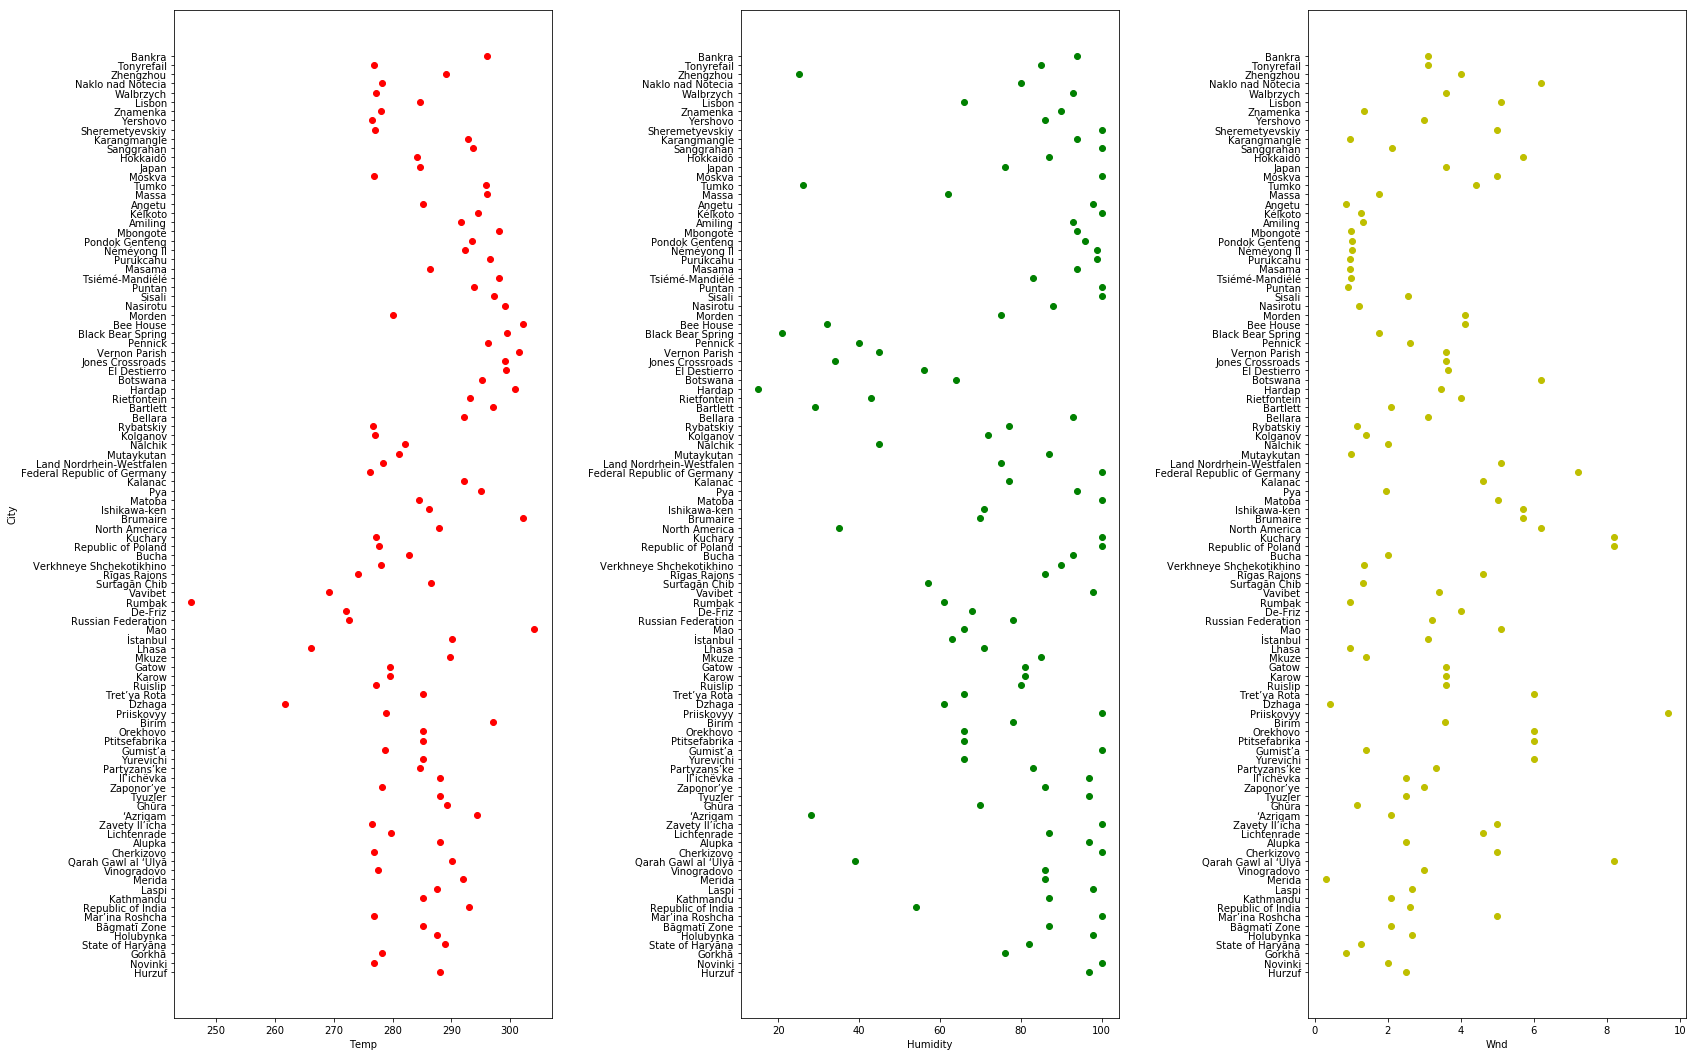

In [6]:
# Given that we have a random sample of cities it is not surprising that the mean is useless. 
# So now we check if there is any correlation between the city and temperatures
plt.subplot(131)
plt.scatter(weather_df.temp,weather_df.index, c='r')
plt.xlabel('Temp')
plt.ylabel('City')

plt.subplot(132)
plt.scatter(weather_df.humidity,weather_df.index, c='g')
plt.xlabel('Humidity')

plt.subplot(133)
plt.scatter(weather_df.wind,weather_df.index, c='y')
plt.xlabel('Wnd')
plt.subplots_adjust(top=4, bottom=0.5, left=0, right=3.5, hspace=5, wspace=0.5)

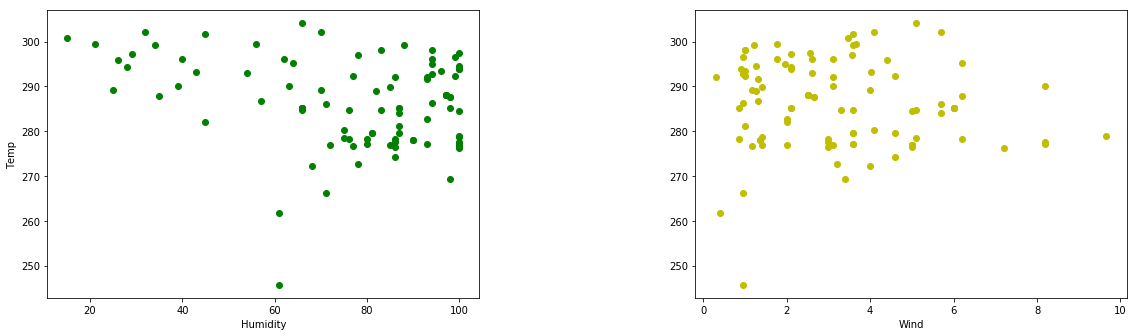

In [7]:
# Surprise, surprise! Not really. As we have random cities, it's just not possible to see any correlation in the plots
# Now we try something more sensible and see if temperature affects humidty and wind
plt.subplot(131)
plt.scatter(weather_df.humidity,weather_df.temp, c='g')
plt.xlabel('Humidity')
plt.ylabel('Temp')

plt.subplot(132)
plt.scatter(weather_df.wind,weather_df.temp, c='y')
plt.xlabel('Wind')
plt.subplots_adjust(top=5, bottom=4, left=1, right=5, hspace=5, wspace=0.5)

# And now we are getting warmer!
# While this is no where conclusive, it seems there is some correlation between temprature and humidity/wind

In [8]:
# Now running an OLS to see the numbers 
result = sm.OLS(endog = np.array(weather_df[['temp']]).astype('float'), exog=np.array(weather_df[['wind', 'humidity']]).astype('float')).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     706.0
Date:                Sun, 28 Oct 2018   Prob (F-statistic):           6.31e-59
Time:                        20:50:21   Log-Likelihood:                -570.78
No. Observations:                 100   AIC:                             1146.
Df Residuals:                      98   BIC:                             1151.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            16.7547      3.265      5.132      0.0

In [9]:
# Interesting! It appears that the line I've fit through my data believes temperature is heavily dependent on wind and humidity
# While this might not make intuitive sense, maybe there's an meteorological explanation for the relationship

In [10]:
# This wasn't part of the assignment but I was interested in playing around with the matplotlib library
# Attempting to see how plotting coordinates and temperature might look and any insights that could be derived?

# I merged withe my cities dataframe from earlier so I have coordinates
# An alternative approach was to change my function above and fetch the coordinates from the API
weather_all = weather_df.merge(cities_df,left_on=['city','country'],right_on=['name', 'country'], how='inner')
display(weather_all.head())

,country,temp,temp_max,temp_min,humidity,pressure,sky,sunrise,sunset,wind,wind_deg,dt,cloudiness,coord.lat,coord.lon,id,name
0,UA,288.121,288.121,288.121,97,1017.05,Clear,04:15 AM,02:36 PM,2.51,None,08:45 PM,0,44.549999,34.283333,707860,Hurzuf
1,RU,276.900,278.150,275.15,100,1018.00,Rain,04:28 AM,01:57 PM,2.00,None,08:00 PM,75,55.683334,37.666668,519188,Novinki
2,RU,276.900,278.150,275.15,100,1018.00,Rain,04:28 AM,01:57 PM,2.00,None,08:00 PM,75,55.849998,38.200001,519207,Novinki
3,RU,276.900,278.150,275.15,100,1018.00,Rain,04:28 AM,01:57 PM,2.00,None,08:00 PM,75,54.981937,37.652126,519212,Novinki
4,NP,278.146,278.146,278.146,76,811.08,Clear,01:30 AM,11:39 AM,0.86,None,08:47 PM,0,28.000000,84.633331,1283378,Gorkhā


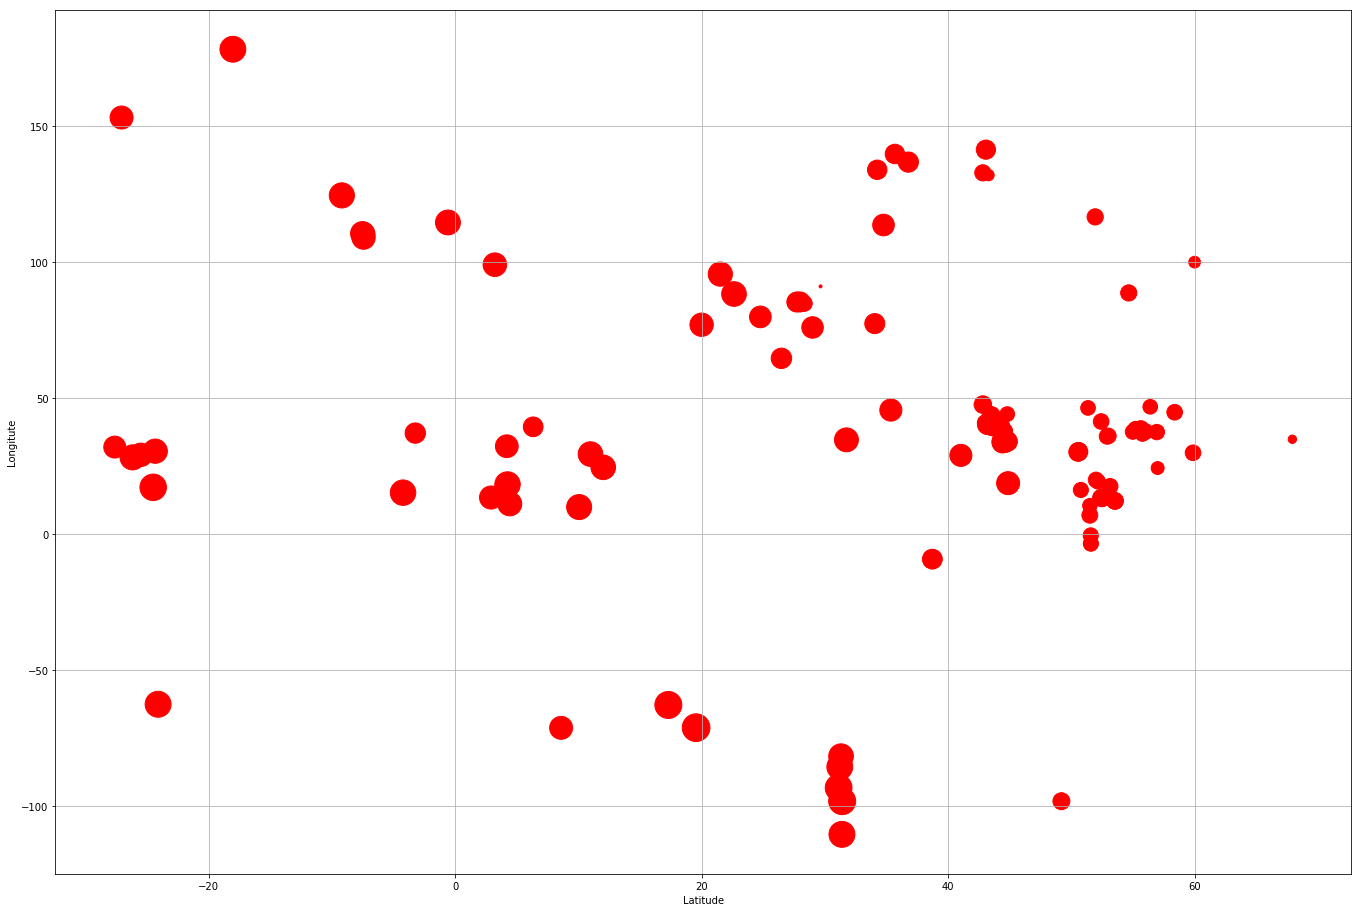

In [11]:
# I want to use the temperature to determine the size of the markers and plugging it into my plot below
# This didn't seem to work initially because of how pandas read the numbers I fetched from the API
temp = np.array(weather_all['temp']).astype('float')
temp = np.abs(temp - temp.min() - 20) * 20

plt.scatter(x = weather_all['coord.lat'], y = weather_all['coord.lon'], s = temp, c = 'r')
plt.xlabel('Latitude')
plt.ylabel('Longitute')
plt.grid(True)
plt.subplots_adjust(top=3, bottom=0, left=0, right=3, hspace=5, wspace=0.5)

# Show the plot
plt.show()

In [1]:
# Nothing particularly insightful to be honest. 
# I theorised that the closer cities were by coordinates, the more similar their temperatures would be. This is vaguely the case.
# Although, as this is a random sample of cities, it might be hard to spot trends at small samples.
# Perhaps if we extended our sample to say 1,000 cities, maybe trends would start to become more obvious.